In [1]:
##this top part is stuff from my original team -- 
##if you want the files penney_db1 you can look at the github link posted in the workgroups
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import penney_db1 as penney_db1
from penney_db1 import *
from importlib import reload
reload(penney_db1);
import os
import numpy as np
import plotly.graph_objects as go

In [3]:
##my group's original function calculating the probabilites
def find_prob(database):
    sql = '''
    WITH TricksWins AS (
        SELECT 
            all_combinations.p1_seq, 
            all_combinations.p2_seq, 
            COALESCE(COUNT(win_results.win_tricks), 0) AS p1_wins_by_tricks
        FROM 
            (SELECT DISTINCT p1_seq, p2_seq FROM win_results) AS all_combinations
        LEFT JOIN 
            win_results ON all_combinations.p1_seq = win_results.p1_seq 
                        AND all_combinations.p2_seq = win_results.p2_seq
                        AND win_results.win_tricks = 'p1'
        GROUP BY 
            all_combinations.p1_seq, 
            all_combinations.p2_seq
    ), 
    CardWins AS (
        SELECT 
            all_combinations.p1_seq, 
            all_combinations.p2_seq, 
            COALESCE(COUNT(win_results.win_cards), 0) AS p1_wins_by_cards
        FROM 
            (SELECT DISTINCT p1_seq, p2_seq FROM win_results) AS all_combinations
        LEFT JOIN 
            win_results ON all_combinations.p1_seq = win_results.p1_seq 
                        AND all_combinations.p2_seq = win_results.p2_seq
                        AND win_results.win_cards = 'p1'
        GROUP BY 
            all_combinations.p1_seq, 
            all_combinations.p2_seq
    ),
    TimesPlayed AS (
        SELECT 
            p1_seq, 
            p2_seq, 
            COUNT(*) AS TimesPlayed
        FROM 
            win_results
        GROUP BY 
            p1_seq, 
            p2_seq
    )
    
    SELECT 
        t.p1_seq, 
        t.p2_seq, 
        IFNULL(t.p1_wins_by_tricks, 0) AS P1TrickWinCount,
        IFNULL(c.p1_wins_by_cards, 0) AS P1CardWinCount,
        tp.TimesPlayed, 
        IFNULL(1.0 * t.p1_wins_by_tricks / tp.TimesPlayed, 0) AS P1ProbWinTricks,
        IFNULL(1.0 * c.p1_wins_by_cards / tp.TimesPlayed, 0) AS P1ProbWinCard
    FROM 
        TricksWins t
    LEFT JOIN 
        CardWins c ON t.p1_seq = c.p1_seq AND t.p2_seq = c.p2_seq
    LEFT JOIN 
        TimesPlayed tp ON t.p1_seq = tp.p1_seq AND t.p2_seq = tp.p2_seq
    ORDER BY t.p1_seq, t.p2_seq asc;
    '''
    return database.run_query(sql)

In [4]:
##connecting to database file -- also uploaded on my orignal group's github
d = DB('../Automation_Workflow/data/example_file.db')

In [5]:
##getting the probabilities
prob_df = find_prob(d)

In [6]:
##getting the probabilites of player 1 winning by cards and tricks
##order of probability arrays are
'''
[(BBB,BBB), (BBB, BBR), .....]
[(BBR, BBB), (BBR, BBR), (BBR,BRB), ....]
[(BRB, BBB), (BRB, BBR), (BRB, BRB), (BRB, BRR),...]
[(BRR, BBB), (....]
'''
prob_p1card=np.reshape(prob_df['P1ProbWinCard'].values, (8,8))
prob_p1tricks=np.reshape(prob_df['P1ProbWinTricks'].values, (8,8))
n=prob_df['TimesPlayed'][0]

In [7]:
##making random data for tie data (diagonals are assumed to be the instances in which both player's guesses are the same)
tie_data_cards=np.random.random((8,8))
tie_data_tricks=np.random.random((8,8))

In [13]:
##making dictionary that we are expected to get from the processing teams
viz_input={'Cards':prob_p1card, 'Card_Ties': tie_data_cards, 'Tricks':prob_p1tricks, 
             'Trick_Ties':tie_data_tricks, 'n':n}

In [30]:
def get_heatmaps(format:str) -> None:
    
    data = viz_input

    ##formatting cards
    cards = viz_input_C['Cards']
    var_cards = np.transpose(np.round((cards)*100,0))
    np.fill_diagonal(var_cards, None)
    
    ##formatting tricks
    tricks = viz_input_C['Tricks']
    var_tricks = np.transpose(np.round((tricks)*100,0))
    np.fill_diagonal(var_tricks, None)
    
    n = data['n']
    
    ##formatting Card_Ties -- card_ties holds just the tie data for winning by cards
    Cties = viz_input_C['Card_Ties']
    card_ties= np.transpose(np.round((Cties)*100,0)) 
    np.fill_diagonal(card_ties, None)

    ##formatting Trick_Ties -- trick_ties holds just the tie data for winning by tricks
    Tties = viz_input_C['Trick_Ties']
    trick_ties = np.transpose(np.round((Tties)*100,0)) 
    np.fill_diagonal(trick_ties, None)
    

    ##building appropriate labels for cards
    ct_labels=[]
    for i in range(len(cards)):
        for j in range(len(Cties)):
            new_cards_ties=str(var_cards[i][j])[:-2]+' ('+str(card_ties[i][j])[:-2]+')'
            ct_labels+=[new_cards_ties]
    ct_labels=np.reshape(ct_labels,(8,8))
    np.fill_diagonal(ct_labels, '')

    ##building appropriate labels for tricks
    tt_labels=[]
    for i in range(len(tricks)):
        for j in range(len(Tties)):
            new_tricks_ties=str(var_tricks[i][j])[:-2]+' ('+str(trick_ties[i][j])[:-2]+')'
            tt_labels+=[new_tricks_ties]
    tt_labels=np.reshape(tt_labels,(8,8))
    np.fill_diagonal(tt_labels, '')

    if format == 'png':
        __create_png(var_cards, ct_labels, var_tricks, tt_labels)
    
    elif format == 'html':
        __create_html(var_cards, ct_labels, var_tricks, tt_labels, card_ties, trick_ties)

    else:
        print('Format unsupported')
    return

    

In [31]:
def __create_png(var_cards, ct_labels, var_tricks, tt_labels) -> None:
        
    x_axis_labels = ['BBB','BBR','BRB','BRR','RBB','RBR','RRB','RRR'] #player 1 
    y_axis_labels = ['BBB','BBR','BRB','BRR','RBB','RBR','RRB','RRR'] #player 2

    ##figure for cards
    
    fig_cards=plt.figure(figsize=(8,8))
    ax_cards = plt.axes()
    
    sns.heatmap(var_cards, annot= ct_labels, fmt="",annot_kws={"size": 10},linewidths=.5,  cmap='Blues', 
                 cbar=False,vmin=0, vmax=100)
    plt.xlabel('Player 1 Guesses', fontsize=14)
    plt.ylabel('Player 2 Guesses', fontsize=14)
    ax_cards.set_xticklabels(x_axis_labels, fontsize=12)
    ax_cards.set_yticklabels(y_axis_labels, fontsize=12)
    ax_cards.set_facecolor('#DBDBDB')

    ##making and adjusting the colorbar
    cbar_ax = fig_cards.add_axes([.95, 0.11, 0.035, .77])
    cb = fig_cards.colorbar(ax_cards.collections[0], cax=cbar_ax)
    cb.outline.set_linewidth(.2)
    
    plt.suptitle("Probability (%) Player 1 Wins Penney's Game by Cards\n(n="+str(n)+'), [Win (Tie)]', y=0.95, fontsize = 17)

    plt.savefig('figures/heatmap_n'+str(n)+"_byCards.png", bbox_inches = 'tight', facecolor = 'white')
    plt.show()

    ##figure for tricks
    
    fig_tricks=plt.figure(figsize=(8,8))
    ax_tricks = plt.axes()
    
    sns.heatmap(var_tricks, annot= tt_labels, fmt="",annot_kws={"size": 10},linewidths=.5,  cmap='Blues', 
                 cbar=False, vmin=0, vmax=100)
    plt.xlabel('Player 1 Guesses', fontsize=14)
    plt.ylabel('Player 2 Guesses', fontsize=14)
    ax_tricks.set_xticklabels(x_axis_labels, fontsize=12)
    ax_tricks.set_yticklabels(y_axis_labels, fontsize=12)
    ax_tricks.set_facecolor('#DBDBDB')

    ##making and adjusting the colorbar
    cbar_ax = fig_tricks.add_axes([.95, 0.11, 0.035, .77])
    cb = fig_tricks.colorbar(ax_cards.collections[0], cax=cbar_ax)
    cb.outline.set_linewidth(.2)
    
    plt.suptitle("Probability (%) Player 1 Wins Penney's Game by Tricks\n(n="+str(n)+'), [Win (Tie)]', y=0.95, fontsize = 17)
    plt.savefig('figures/heatmap_n'+str(n)+"_byTricks.png", bbox_inches = 'tight', facecolor = 'white')
    plt.show()
    return

In [34]:
def __create_html(var_cards, ct_labels, var_tricks, tt_labels, card_ties, trick_ties) -> None:
    
    ##figure for cards
    
    card_data=np.flip(var_cards,0)
    tie_card_insert=np.flip(card_ties,0)

    fig = go.Figure(data = go.Heatmap(
                   z = card_data, colorscale = 'blues', 
                   customdata=tie_card_insert,
                   hovertemplate = "P1: %{x}, P2: %{y}<br>P1 Win Probability: %{z}%<br>Tie Probability: %{customdata}%", name = "",
                   text=np.flip(ct_labels,0),  texttemplate='%{text}',
                   x = ['BBB','BBR','BRB','BRR','RBB','RBR','RRB','RRR'],
 
                   y = ['RRR', 'RRB', 'RBR', 'RBB', 'BRR', 'BRB', 'BBR', 'BBB'],
                   hoverongaps = False,
                colorbar=dict(
                tickvals=[0, 20, 40, 60, 80, 100],  # Positions of the ticks
                ticktext=[0, 20, 40, 60, 80, 100],   # Labels for the ticks
                outlinewidth=1,  # Thin outline width
                outlinecolor="#E7E7E7" 
                ),
                zmin=0,
                zmax=100
    ))
    fig.update_layout(
        title = "Probability (%) Player 1 Wins Penney's Game by Cards<br>(n="+str(n)+'), [Win (Tie)]', 
        plot_bgcolor="#DBDBDB",
        title_x = 0.5,
        title_y = 0.94,
        title_font_size = 22,
        xaxis = dict(
            title = 'Player 1 Guesses',
            title_font = dict(size=18),
            tickfont=dict(size=16)
        ),
        yaxis = dict(
            title = 'Player 2 Guesses',
            title_font = dict(size=18),
            tickfont=dict(size=16)
        ),
        width = 750,
        height = 750

                )
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.update_traces(
        xgap = 1, ygap = 1, textfont_size=13
        )

    fig.show()
    path = "figures/heatmap_n"+str(n)+"_byCards.html"
    fig.write_html(path)

    ##figure for tricks

    trick_data=np.flip(var_tricks,0)
    tie_trick_insert=np.flip(trick_ties,0)

    fig = go.Figure(data = go.Heatmap(
       z = trick_data, colorscale = 'blues',
       customdata=tie_trick_insert,
       hovertemplate = "P1: %{x}, P2: %{y}<br>P1 Win Probability: %{z}%<br>Tie Probability: %{customdata}%", name = "", 
       text=np.flip(tt_labels,0),  texttemplate='%{text}',
       x = ['BBB','BBR','BRB','BRR','RBB','RBR','RRB','RRR'],

       y = ['RRR', 'RRB', 'RBR', 'RBB', 'BRR', 'BRB', 'BBR', 'BBB'],
       hoverongaps = False,
       colorbar=dict(tickvals=[0, 20, 40, 60, 80, 100],  # Positions of the ticks
       ticktext=[0, 20, 40, 60, 80, 100],   # Labels for the ticks
       outlinewidth=1,  # Thin outline width
       outlinecolor='#E7E7E7' 
        ),
        zmin=0,
        zmax=100
    ))

    fig.update_layout(
        title = "Probability (%) Player 1 Wins Penney's Game by Tricks<br>(n="+str(n)+'), [Win (Tie)]', 
        plot_bgcolor="#DBDBDB",
        title_x = 0.5,
        title_y = 0.94,
        title_font_size = 22,
        xaxis = dict(
            title = 'Player 1 Guesses',
            title_font = dict(size=18),
            tickfont=dict(size=16)
        ),
        yaxis = dict(
            title = 'Player 2 Guesses',
            title_font = dict(size=18),
            tickfont=dict(size=16)
        ),
        width = 750,
        height = 750
        
        )
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.update_traces(
            xgap = 1, ygap = 1, textfont_size=13
            )
    
    fig.show()
    path = "figures/heatmap_n"+str(n)+"_byTricks.html"
    fig.write_html(path)
    return


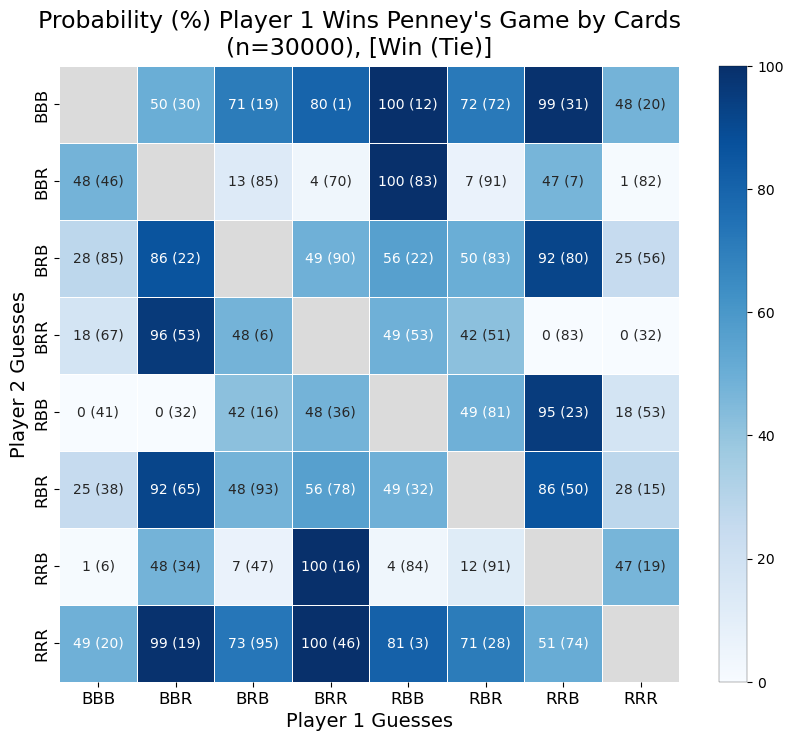

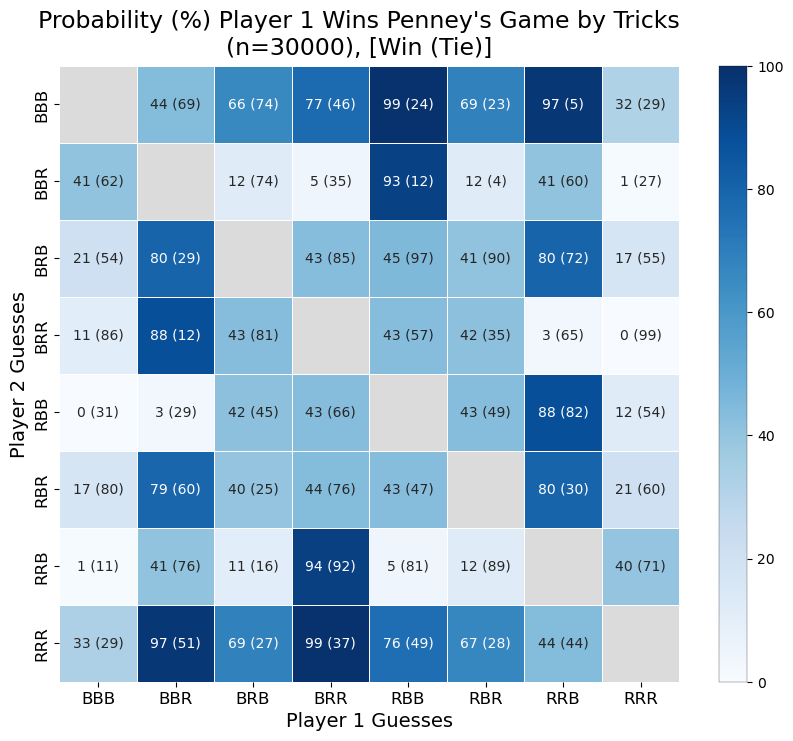

In [33]:
get_heatmaps('png')

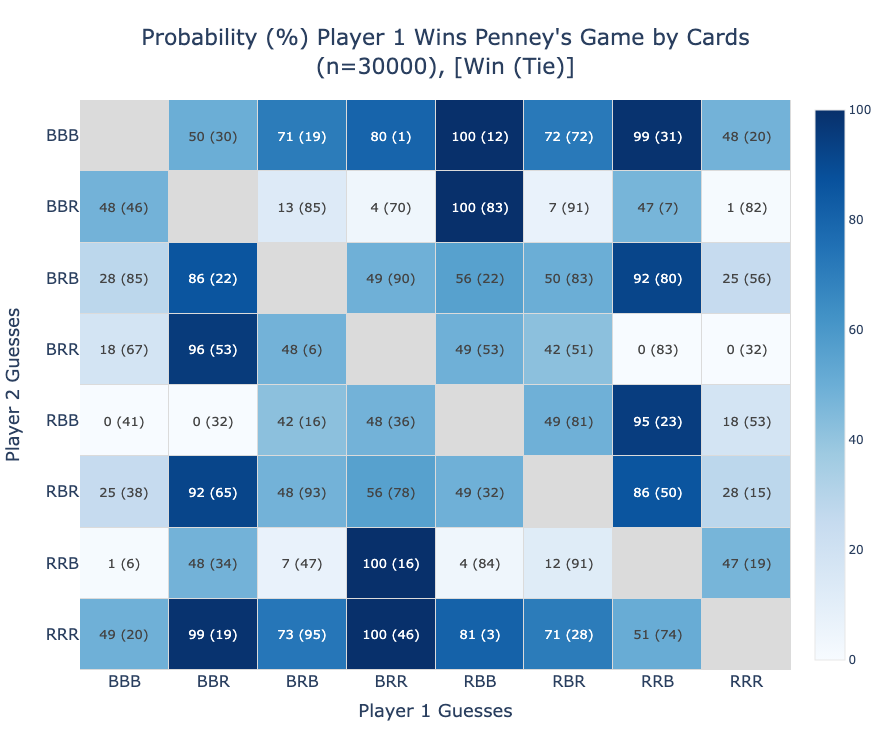

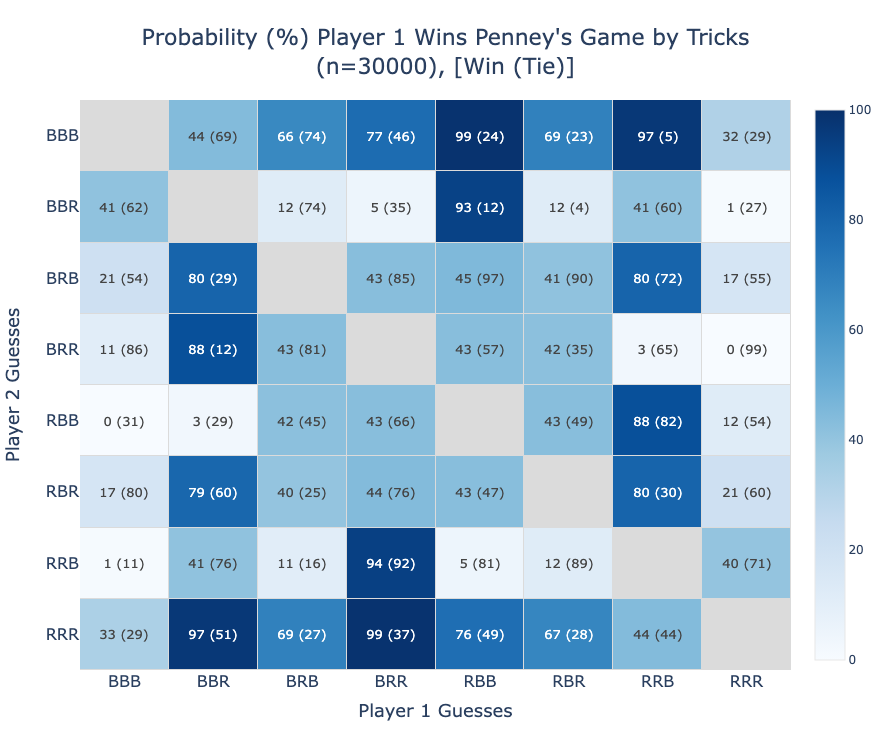

In [35]:
get_heatmaps('html')

In [37]:
d.close()